In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, SGD, RMSprop
from keras.activations import relu, selu, elu
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
plt.rcParams['font.size'] = 12
plt.rcParams['lines.color'] ='#000000'
np.random.seed(1234567)

In [2]:
train_path = '../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv'
test_path = '../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv'

In [3]:
train = pd.read_csv(train_path) # import data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
print('shape of training data:', train.shape) # (nrow, ncolumn)

''' na count over all rows and columns
first sum = sums over rows, last sum = sums over columns
'''
print('na count:', train.isna().sum().sum())

shape of training data: (27455, 785)
na count: 0


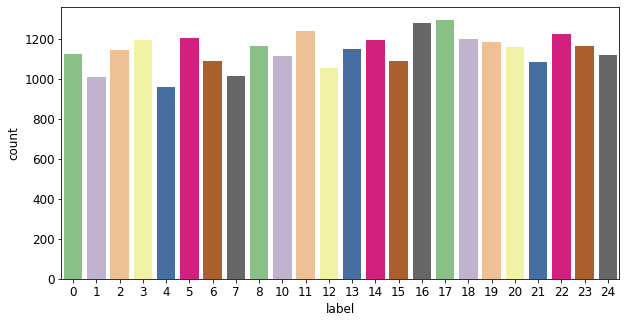

In [5]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=train, palette='Accent')
plt.show()

In [6]:
target_counts = train['label'].value_counts()
target_counts = round(target_counts * 100 / target_counts.sum())
print('majority : minority class ratio =', target_counts.max(), ':', target_counts.min()) # no class imbalance

majority : minority class ratio = 5.0 : 3.0


In [7]:
X = train.drop('label', axis=1) # features
y = to_categorical(train['label']) # one-hot encoded target

In [8]:
# reshape square black and white images
def reshape_bw(X):
    samples, width, channel = X.shape[0], int(X.shape[1] ** (1/2)) , 1
    return X.values.reshape(samples, width, width, channel)  

In [9]:
X = reshape_bw(X)
width, height, channel = X.shape[1], X.shape[2], X.shape[3]

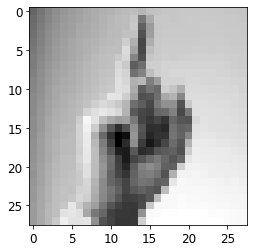

In [10]:
# plot a square black and white image
def plot_image(X, width):
    _ = plt.imshow(X.reshape(width, width), cmap='gray')
    plt.show()
    
plot_image(X[0], width) # plot sample image

In [11]:
# split data into train and validation set with same target distribution as before spliting
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [12]:
# create data preprocessor and fit on train set
generator = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    height_shift_range=0.15,
    width_shift_range=0.15, 
    fill_mode='nearest'
)
generator.fit(X_train)

In [13]:
# initialize model
def build_model(func):
    model = Sequential()
    model.add(Conv2D(64, (5, 5), padding="same", input_shape=(width, height, channel)))
    model.add(BatchNormalization())
    model.add(Activation(func))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (5, 5), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation(func))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (5, 5), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation(func))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation(func))
    model.add(Dropout(0.25))
    model.add(Dense(y.shape[1], activation='softmax'))
    return model

In [14]:
from keras.metrics import Precision, Recall, AUC

model_relu = build_model(relu)
model_elu = build_model(elu)

# compile models
model_relu.compile(
    optimizer=Adam(learning_rate=0.009),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC(name='auc')]
)

model_elu.compile(
    optimizer=Adam(learning_rate=0.009),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC(name='auc')]
)

In [15]:
# deine model callnbaks
cb_relu = [ModelCheckpoint('model_relu.h5', monitor='val_auc', mode='max',save_best_only=True), 
            ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

cb_elu = [ModelCheckpoint('model_elu.h5', monitor='val_auc', mode='max',save_best_only=True), 
            ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [16]:
history_relu = model_relu.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=25, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_relu,
                    verbose=2)

Epoch 1/25
687/687 - 16s - loss: 1.0344 - accuracy: 0.6697 - precision: 0.8595 - recall: 0.5630 - auc: 0.9732 - val_loss: 0.3222 - val_accuracy: 0.8882 - val_precision: 0.9084 - val_recall: 0.8689 - val_auc: 0.9967
Epoch 2/25
687/687 - 10s - loss: 0.1782 - accuracy: 0.9413 - precision: 0.9517 - recall: 0.9323 - auc: 0.9983 - val_loss: 0.0322 - val_accuracy: 0.9911 - val_precision: 0.9918 - val_recall: 0.9898 - val_auc: 0.9998
Epoch 3/25
687/687 - 10s - loss: 0.1020 - accuracy: 0.9674 - precision: 0.9724 - recall: 0.9634 - auc: 0.9989 - val_loss: 0.0499 - val_accuracy: 0.9836 - val_precision: 0.9847 - val_recall: 0.9820 - val_auc: 0.9995
Epoch 4/25
687/687 - 10s - loss: 0.0768 - accuracy: 0.9753 - precision: 0.9786 - recall: 0.9732 - auc: 0.9992 - val_loss: 0.0528 - val_accuracy: 0.9811 - val_precision: 0.9848 - val_recall: 0.9778 - val_auc: 0.9995
Epoch 5/25
687/687 - 11s - loss: 0.0175 - accuracy: 0.9940 - precision: 0.9946 - recall: 0.9934 - auc: 1.0000 - val_loss: 7.4681e-04 - val_a

In [17]:
history_elu = model_elu.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=25, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_elu,
                    verbose=2)

Epoch 1/25
687/687 - 12s - loss: 0.9540 - accuracy: 0.6943 - precision_1: 0.8609 - recall_1: 0.5914 - auc: 0.9772 - val_loss: 0.1652 - val_accuracy: 0.9432 - val_precision_1: 0.9519 - val_recall_1: 0.9377 - val_auc: 0.9988
Epoch 2/25
687/687 - 11s - loss: 0.1959 - accuracy: 0.9343 - precision_1: 0.9464 - recall_1: 0.9241 - auc: 0.9981 - val_loss: 0.0587 - val_accuracy: 0.9801 - val_precision_1: 0.9830 - val_recall_1: 0.9772 - val_auc: 0.9997
Epoch 3/25
687/687 - 10s - loss: 0.1081 - accuracy: 0.9627 - precision_1: 0.9684 - recall_1: 0.9587 - auc: 0.9989 - val_loss: 0.0172 - val_accuracy: 0.9940 - val_precision_1: 0.9949 - val_recall_1: 0.9934 - val_auc: 1.0000
Epoch 4/25
687/687 - 10s - loss: 0.0733 - accuracy: 0.9764 - precision_1: 0.9792 - recall_1: 0.9745 - auc: 0.9992 - val_loss: 0.0522 - val_accuracy: 0.9843 - val_precision_1: 0.9849 - val_recall_1: 0.9838 - val_auc: 0.9989
Epoch 5/25
687/687 - 11s - loss: 0.0691 - accuracy: 0.9773 - precision_1: 0.9798 - recall_1: 0.9759 - auc: 0

In [18]:
def plot_learning_curve(history, activation_func):
    print(f"learning curve of model with activation {activation_func}")
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['accuracy', 'val_accuracy'])
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.show()

learning curve of model with activation relu


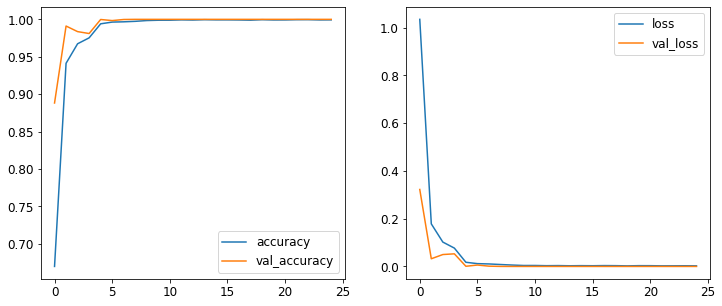

In [19]:
plot_learning_curve(history_relu, relu.__name__)

learning curve of model with activation elu


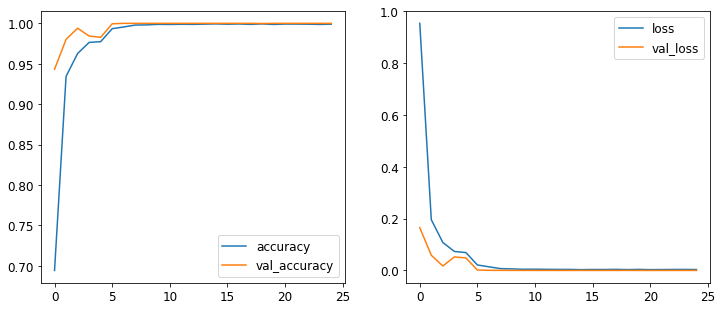

In [20]:
plot_learning_curve(history_elu, elu.__name__)

In [21]:
# evaluate model on unseen data
test = pd.read_csv(test_path)
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


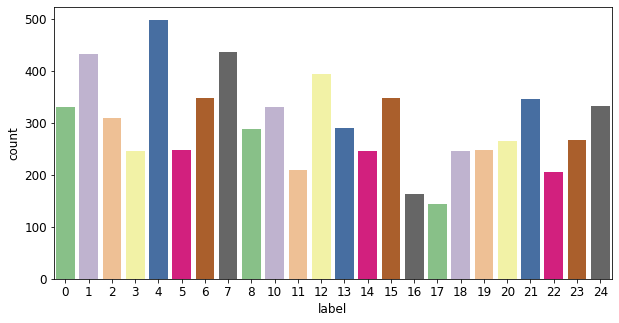

In [22]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=test, palette='Accent')
plt.show()

In [23]:
X_test = test.drop('label', axis=1)
y_test = test['label']
X_test = reshape_bw(X_test)
y_test = to_categorical(y_test)

In [24]:
def evaluate(model, activation_func):
    print(f"evaluating model with {activation_func} activation")
    loss, acc, pre, rec, auc = model.evaluate(generator.flow(X_test,y_test,batch_size=32))
    print()
    print(f"test loss: {loss}")
    print(f"test accuracy: {round(acc*100,2)} %")
    print(f"test precision: {pre}")
    print(f"test recall: {rec}")
    print(f"test AUC: {auc}")
    print()
    index = 2001
    print(f"label: {np.argmax(model.predict(np.expand_dims([X_test[index]], axis=-1), verbose=0))}")
    print(f"actual label: {np.argmax(y_test[index], axis=-1)}")
    plot_image(X_test[index], width)

evaluating model with relu activation
225/225 [==============================] - 3s 12ms/step - loss: 8.8592e-04 - accuracy: 0.9997 - precision: 0.9999 - recall: 0.9996 - auc: 1.0000

test loss: 0.0008859235676936805
test accuracy: 99.97 %
test precision: 0.9998605251312256
test recall: 0.9995816946029663
test AUC: 0.9999999403953552

label: 2
actual label: 2


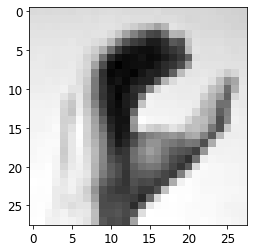

In [25]:
evaluate(model_relu, relu.__name__)

evaluating model with elu activation
225/225 [==============================] - 3s 12ms/step - loss: 0.0042 - accuracy: 0.9986 - precision_1: 0.9987 - recall_1: 0.9985 - auc: 0.9999

test loss: 0.004163230769336224
test accuracy: 99.86 %
test precision: 0.998744785785675
test recall: 0.9984662532806396
test AUC: 0.9999299049377441

label: 2
actual label: 2


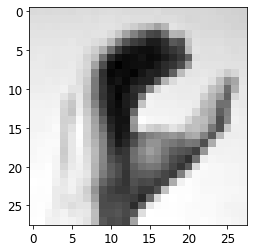

In [26]:
evaluate(model_elu, elu.__name__)

In [27]:
from sklearn.metrics import confusion_matrix
def plot_confmat(model, activation_func):   
    print(f"confusion matrix of model with {activation_func} activation")
    cm = confusion_matrix(test['label'], model.predict(X_test).argmax(-1))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap=plt.cm.Purples)
    plt.ylabel('actual')
    plt.xlabel('predicted')
    plt.show()

confusion matrix of model with relu activation


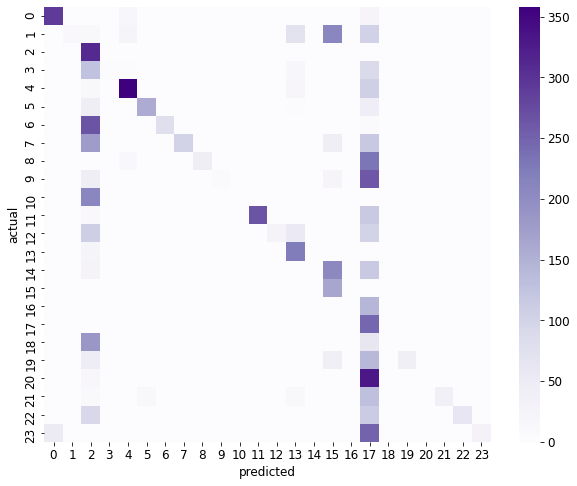

In [28]:
plot_confmat(model_relu, relu.__name__)

confusion matrix of model with elu activation


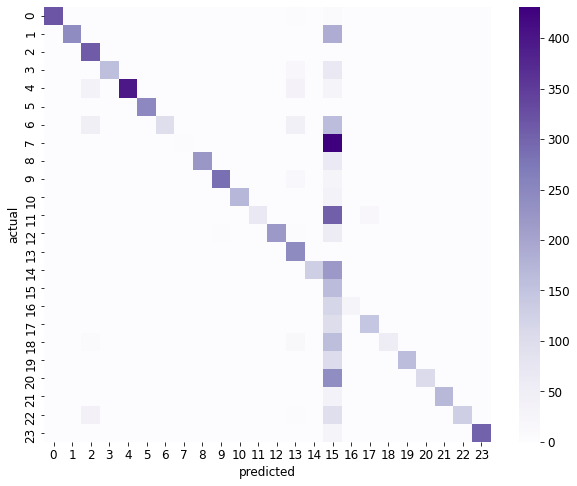

In [29]:
plot_confmat(model_elu, elu.__name__)